<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula05c_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)
  plt.xlim(0, 1)
  plt.ylim(0, 1)

In [227]:
import numpy as np

def plotHiperplano(vector, intercept=0):
  xs = np.array([0, 1])
  ys = -(vector[0]*xs+intercept)/vector[1]
  plt.plot(xs, ys, 'r-')

In [230]:
def criaDataset(n=20, slop=[2,1], intercept=-0.4, dummyFeatures=8):
  X = np.random.uniform(size=(n,dummyFeatures+2))
  AUX = X[:,:2] * np.array(slop) - [0, intercept]
  y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
  return X, y

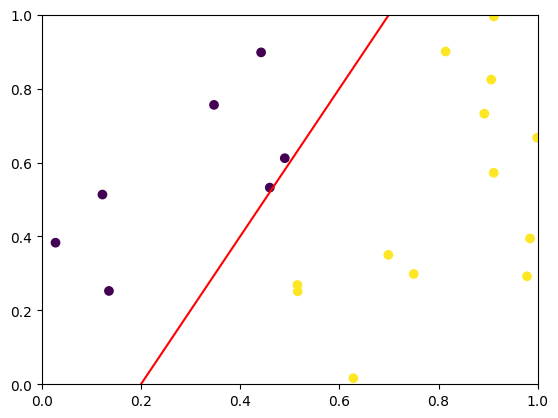

In [234]:
X, y = criaDataset()
plotDataset(X, y)
plotHiperplano([2, -1], -0.4)
plt.show()

In [235]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def sign(a):
  return (a>=0)*2-1

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

In [236]:
from abc import ABC, abstractmethod, abstractstaticmethod

class Cost(ABC):
  @abstractstaticmethod
  def getCost(y, ypred):
    pass
  @abstractstaticmethod
  def getGradient(y, ypred):
    pass

class WidrowHoff(Cost):
  @staticmethod
  def getCost(y, ypred):
    return 0.5 * (y - ypred) ** 2
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y - ypred)

class SmoothedSurrogate(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y - sign(ypred))

class HingeLoss(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1 - y*ypred))
  @staticmethod
  def getGradient(y, ypred, X):
    marginalserrors = (y * ypred) < 1
    marginal_ys = np.copy(y)
    marginal_ys[~marginalserrors] = 0
    return X.T @ marginal_ys

class LogLikehood(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y - np.tanh(ypred))


In [237]:
class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y):
    pass

class GradientDescent(TrainingAlgorithm):
  def __init__(self, learning_rate=0.05, n_iter=100,
               regularization=0,
               cost=WidrowHoff()):
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(size=X.shape[1])*2-1
    for _ in range(self.n_iter):
      ypred = X @ w
      error = y-ypred
      w *= 1 - self.learning_rate * self.regularization
      w += self.learning_rate * self.cost.getGradient(y, ypred, X)
    return w

In [238]:
class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, trainingAlgorithm=GradientDescent()):
    self.trainingAlgorithm = trainingAlgorithm

  def fit(self, X, y):
    Xb = include_bias(X)
    self.w = self.trainingAlgorithm.getW(Xb, y)
    return self

  def predict(self, X):
    Xb = include_bias(X)
    return sign(Xb @ (self.w))


In [239]:
Xtest, ytest = criaDataset(1000)

In [274]:
for c in [0, 0.5, 1, 10, 100]:
  model = Perceptron(GradientDescent(regularization=c, cost=WidrowHoff()))
  model.fit(X, y)
  ypred = model.predict(Xtest)
  print(f"{model.trainingAlgorithm.cost.__class__} , c={c}\t", accuracy_score(ytest, ypred))

<class '__main__.WidrowHoff'> , c=0	 0.539
<class '__main__.WidrowHoff'> , c=0.5	 0.461
<class '__main__.WidrowHoff'> , c=1	 0.539
<class '__main__.WidrowHoff'> , c=10	 0.539
<class '__main__.WidrowHoff'> , c=100	 0.461


In [254]:
for c in [0, 0.5, 1, 10, 100]:
  model = Perceptron(GradientDescent(regularization=c, cost=SmoothedSurrogate()))
  model.fit(X, y)
  ypred = model.predict(Xtest)
  print(f"{model.trainingAlgorithm.cost.__class__} , c={c}\t", accuracy_score(ytest, ypred))

<class '__main__.SmoothedSurrogate'> , c=0	 0.827
<class '__main__.SmoothedSurrogate'> , c=0.5	 0.874
<class '__main__.SmoothedSurrogate'> , c=1	 0.868
<class '__main__.SmoothedSurrogate'> , c=10	 0.539
<class '__main__.SmoothedSurrogate'> , c=100	 0.537


In [261]:
for c in [0, 0.5, 1, 10, 100]:
  model = Perceptron(GradientDescent(regularization=c, cost=HingeLoss()))
  model.fit(X, y)
  ypred = model.predict(Xtest)
  print(f"{model.trainingAlgorithm.cost.__class__} , c={c}\t", accuracy_score(ytest, ypred))

<class '__main__.HingeLoss'> , c=0	 0.882
<class '__main__.HingeLoss'> , c=0.5	 0.606
<class '__main__.HingeLoss'> , c=1	 0.823
<class '__main__.HingeLoss'> , c=10	 0.461
<class '__main__.HingeLoss'> , c=100	 0.39


In [266]:
for c in [0, 0.5, 1, 10, 100]:
  model = Perceptron(GradientDescent(regularization=c, cost=LogLikehood()))
  model.fit(X, y)
  ypred = model.predict(Xtest)
  print(f"{model.trainingAlgorithm.cost.__class__} , c={c}\t", accuracy_score(ytest, ypred))

<class '__main__.LogLikehood'> , c=0	 0.885
<class '__main__.LogLikehood'> , c=0.5	 0.89
<class '__main__.LogLikehood'> , c=1	 0.783
<class '__main__.LogLikehood'> , c=10	 0.461
<class '__main__.LogLikehood'> , c=100	 0.461


In [286]:
costs = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikehood()]

for cost in costs:
  model = Perceptron(GradientDescent(cost=cost))
  model.fit(X, y)
  ypred = model.predict(Xtest)
  print(f"{model.trainingAlgorithm.cost.__class__}\t", accuracy_score(ytest, ypred))

<class '__main__.WidrowHoff'>	 0.539
<class '__main__.SmoothedSurrogate'>	 0.846
<class '__main__.HingeLoss'>	 0.882
<class '__main__.LogLikehood'>	 0.9
